Market Mix Modeling (MMM) with linear regression is a technique used to analyze the impact of various marketing channels on sales.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import os
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### Data Preprocessing

In [26]:
data = pd.read_csv('C:/Users/DELL/personal_projects/linReg_MMM/data/Sample Media Spend Data.csv')


In [27]:
data

,Division,Calendar_Week,Paid_Views,Organic_Views,Google_Impressions,Email_Impressions,Facebook_Impressions,Affiliate_Impressions,Overall_Views,Sales
0,A,1/6/2018,392,422,408,3.498950e+05,73580,12072,682,59417
1,A,1/13/2018,787,904,110,5.062702e+05,11804,9499,853,56806
2,A,1/20/2018,81,970,742,4.300422e+05,52232,17048,759,48715
3,A,1/27/2018,25,575,65,4.177457e+05,78640,10207,942,72047
4,A,2/3/2018,565,284,295,4.085058e+05,40561,5834,658,56235
...,...,...,...,...,...,...,...,...,...,...
3046,Z,2/1/2020,29239,25311,622406,1.459071e+06,45026,12098,53667,82707
3047,Z,2/8/2020,26230,28031,624409,5.342505e+05,227070,9548,53665,84503
3048,Z,2/15/2020,24749,31281,439362,4.227182e+05,393685,9861,55561,147325
3049,Z,2/22/2020,20713,30356,464178,6.085799e+05,424676,10221,49221,111525


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3051 entries, 0 to 3050
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Division               3051 non-null   object 
 1   Calendar_Week          3051 non-null   object 
 2   Paid_Views             3051 non-null   int64  
 3   Organic_Views          3051 non-null   int64  
 4   Google_Impressions     3051 non-null   int64  
 5   Email_Impressions      3051 non-null   float64
 6   Facebook_Impressions   3051 non-null   int64  
 7   Affiliate_Impressions  3051 non-null   int64  
 8   Overall_Views          3051 non-null   int64  
 9   Sales                  3051 non-null   int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 238.5+ KB


In [34]:
data['Calendar_Week'] = pd.to_datetime(data['Calendar_Week'], format ='%m/%d/%Y')

In [37]:
#check null
data.isnull().sum()

Division                 0
Calendar_Week            0
Paid_Views               0
Organic_Views            0
Google_Impressions       0
Email_Impressions        0
Facebook_Impressions     0
Affiliate_Impressions    0
Overall_Views            0
Sales                    0
dtype: int64

oh it is a clean dataset

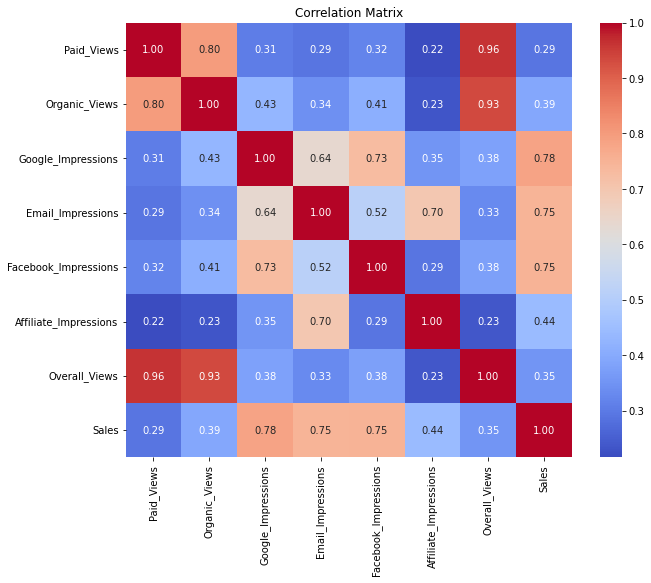

In [38]:

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


From this corr matrix we can note: 
* paid and  organic views are correlated and have a strong effect on the overall views which is logic.
* Google impression are correlatd with facebook and email impression which may suggest that people who get the add on facebook goes and search about it in google, or that the ads in facebok have links that takes uto a google website.
* emails are correlates with the affiliate impressions
* google, email and facebook has an influence on the sales.
* However Youtube has no significant effect on sales :/

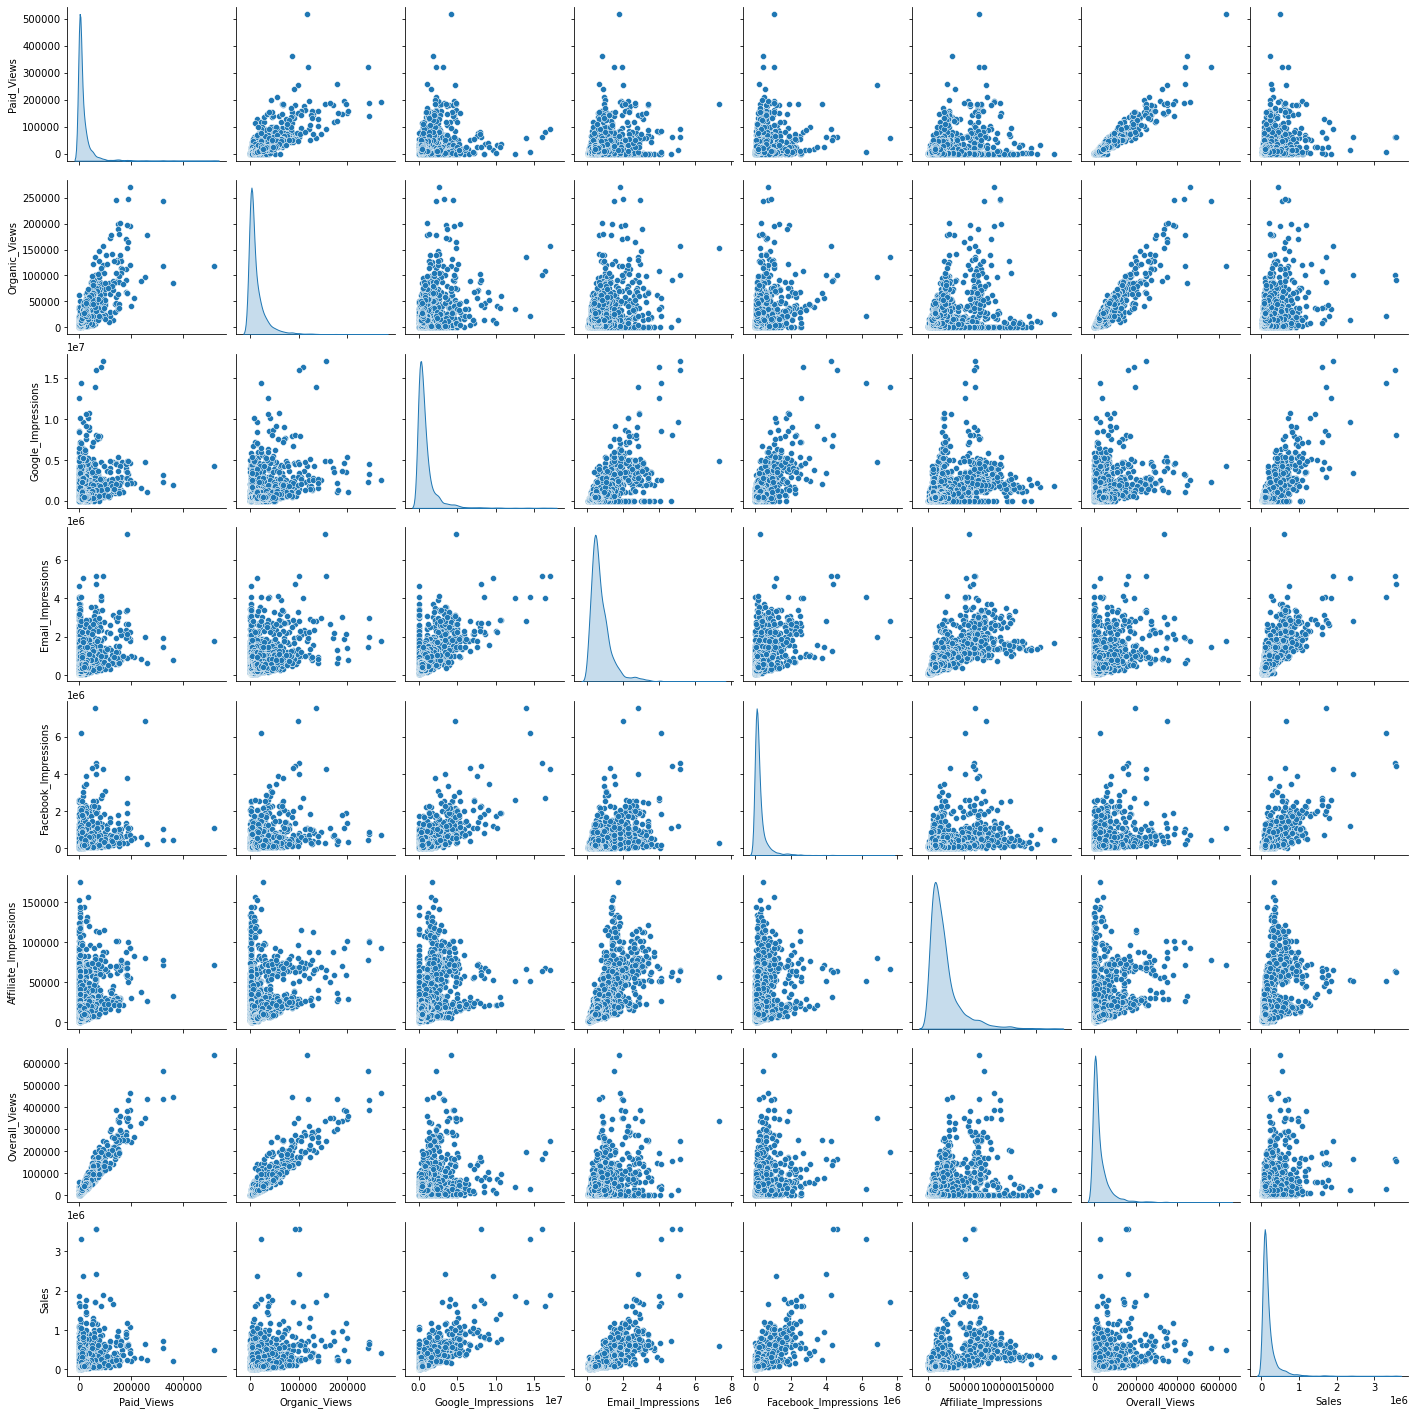

In [40]:
# Select the columns you want to include in the pair plot
columns_to_include = ['Paid_Views', 'Organic_Views', 'Google_Impressions', 'Email_Impressions', 'Facebook_Impressions', 'Affiliate_Impressions', 'Overall_Views', 'Sales']

# Create a pair plot
sns.pairplot(data[columns_to_include], diag_kind='kde')  # 'diag_kind' specifies the type of diagonal plot (kernel density estimate)
plt.show()


In [87]:
#(we can notice that our data has a lot of outliners)

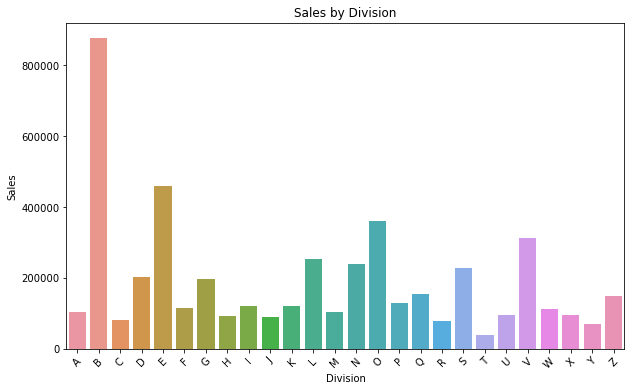

In [45]:
# Create a bar plot of Division vs. Sales
plt.figure(figsize=(10, 6))
sns.barplot(x='Division', y='Sales', data=data, ci=None)  # ci=None to suppress confidence intervals
plt.title('Sales by Division')
plt.xlabel('Division')
plt.ylabel('Sales')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [46]:
#devision B has the most sales

#### Outliners

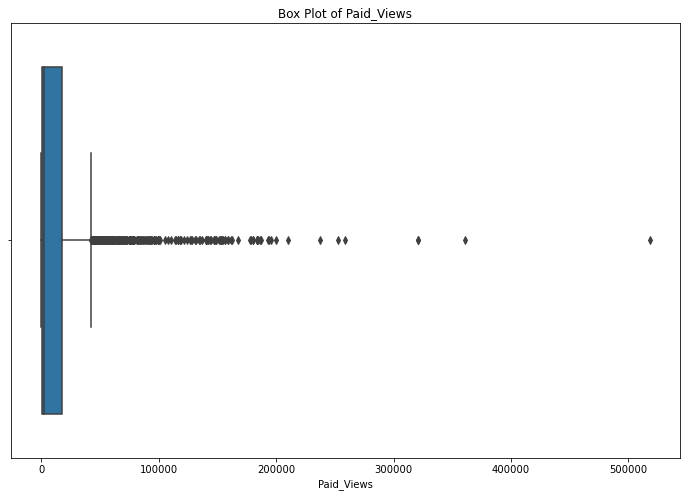

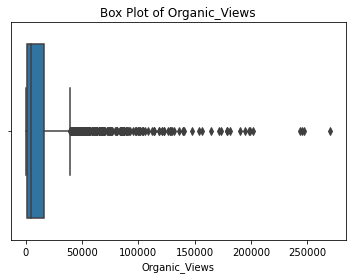

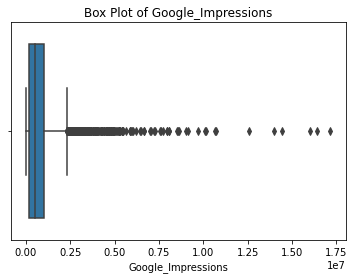

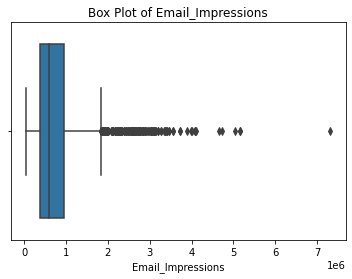

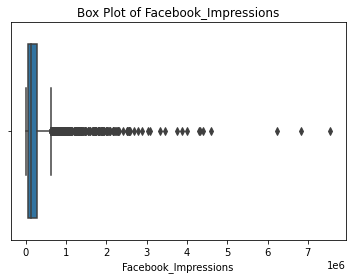

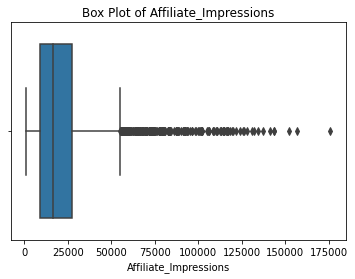

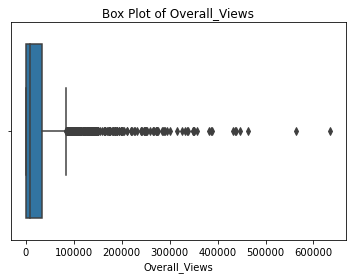

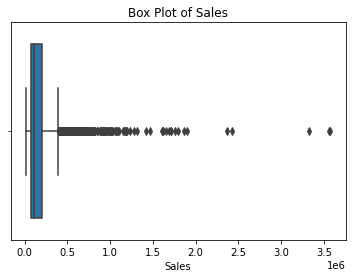

In [84]:
# Create box plots for multiple numeric variables
numeric_columns = ['Paid_Views', 'Organic_Views', 'Google_Impressions', 'Email_Impressions', 'Facebook_Impressions', 'Affiliate_Impressions', 'Overall_Views','Sales']

plt.figure(figsize=(12, 8))  # Set the figure size (optional)

# Loop through each numeric column and create a box plot
for col in numeric_columns:
    sns.boxplot(x=data[col])
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.show()

In [93]:
from scipy.stats.mstats import winsorize

# Set the proportion of data to keep (e.g., 0.025 for 2.5% on each side)
proportion_to_keep = 0.95

# List of variables to winsorize
variables_to_winsorize = ['Paid_Views', 'Organic_Views', 'Google_Impressions', 'Email_Impressions', 'Facebook_Impressions', 'Affiliate_Impressions', 'Overall_Views', 'Sales']

# Apply winsorization to each variable
for variable in variables_to_winsorize:
    data[variable + '_winsorized'] = winsorize(data[variable], limits=(1 - proportion_to_keep) / 2)



### Feature Engineering

In [95]:
# Extract week, month, and year
data['Week'] = data['Calendar_Week'].dt.week
data['Month'] = data['Calendar_Week'].dt.month
data['Year'] = data['Calendar_Week'].dt.year

C:\Users\DELL\AppData\Local\Temp\ipykernel_18424\3861864001.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['Week'] = data['Calendar_Week'].dt.week


In [96]:
data['Day'] = data['Calendar_Week'].dt.day

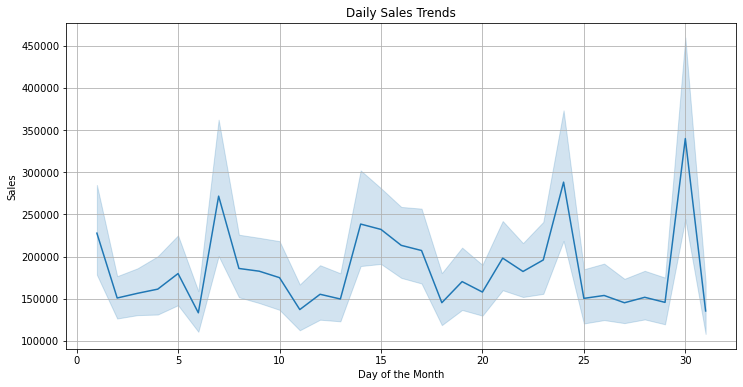

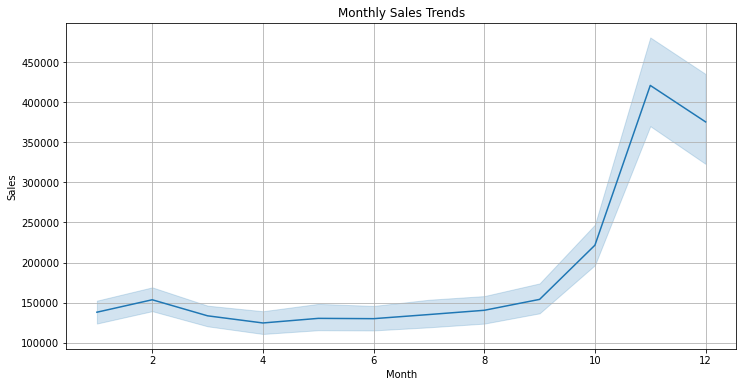

In [97]:
# Create a line plot for daily sales
plt.figure(figsize=(12, 6))
sns.lineplot(x='Day', y='Sales', data=data)
plt.title('Daily Sales Trends')
plt.xlabel('Day of the Month')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

# Create a line plot for monthly sales
plt.figure(figsize=(12, 6))
sns.lineplot(x='Month', y='Sales', data=data)
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.grid(True)
plt.show()


In [44]:
#we notic that in the end of the month and in the end of the year sales augmente and that due to the fact that most people get their paycheck at the end of each month and that the year end is full of festivals so it infuence the customers consumation 

###  Data Splitting

I am not sure f the division represents a state of the us or other thing so i will train my models with and without this variable and see if it has an impact on our overrall result

In [98]:
#Division is categorical variable so let modify it usinh one hot encoding
data_with_dummies = pd.get_dummies(data, columns=['Division'], drop_first=False)

In [99]:
data_with_dummies.columns

Index(['Calendar_Week', 'Paid_Views', 'Organic_Views', 'Google_Impressions',
       'Email_Impressions', 'Facebook_Impressions', 'Affiliate_Impressions',
       'Overall_Views', 'Sales', 'Week', 'Month', 'Year', 'Day',
       'Paid_Views_log', 'Organic_Views_log', 'Google_Impressions_log',
       'Email_Impressions_log', 'Facebook_Impressions_log',
       'Affiliate_Impressions_log', 'Overall_Views_log', 'Sales_log',
       'Paid_Views_winsorized', 'Organic_Views_winsorized',
       'Google_Impressions_winsorized', 'Email_Impressions_winsorized',
       'Facebook_Impressions_winsorized', 'Affiliate_Impressions_winsorized',
       'Overall_Views_winsorized', 'Sales_winsorized', 'Division_A',
       'Division_B', 'Division_C', 'Division_D', 'Division_E', 'Division_F',
       'Division_G', 'Division_H', 'Division_I', 'Division_J', 'Division_K',
       'Division_L', 'Division_M', 'Division_N', 'Division_O', 'Division_P',
       'Division_Q', 'Division_R', 'Division_S', 'Division_T', 'Divis

In [100]:
# Define independent variables (X) and the dependent variable (y)
X = data[['Paid_Views', 'Organic_Views', 'Google_Impressions', 'Email_Impressions', 'Facebook_Impressions', 'Affiliate_Impressions']]
X = sm.add_constant(X)  # Add a constant term (intercept) to the model
y = data['Sales']

In [101]:
# Model with Division as a predictor
X_with_division = data_with_dummies[['Paid_Views', 'Organic_Views', 'Google_Impressions', 'Email_Impressions', 'Facebook_Impressions', 'Affiliate_Impressions', 'Overall_Views', 'Division_A',
       'Division_B', 'Division_C', 'Division_D', 'Division_E', 'Division_F',
       'Division_G', 'Division_H', 'Division_I', 'Division_J', 'Division_K',
       'Division_L', 'Division_M', 'Division_N', 'Division_O', 'Division_P',
       'Division_Q', 'Division_R', 'Division_S', 'Division_T', 'Division_U',
       'Division_V', 'Division_W', 'Division_X', 'Division_Y', 'Division_Z']]
X_with_division = sm.add_constant(X_with_division)
Y_with_division = data_with_dummies['Sales']

In [102]:
from sklearn.model_selection import train_test_split

# Split your existing data into training and testing sets
X_traind, X_testd, y_traind, y_testd = train_test_split(X_with_division, Y_with_division, test_size=0.2, random_state=42)


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Model training

#### With and Without Division

I did some research and I found that for "statistical analysis, Statsmodels may be a better choice compared to Scikit-learn " However both are extremely powerful and because we are dealing with an MMM problem I chose Statsmodels.

In [104]:
model_without_division = sm.OLS(y_train, X_train).fit()

In [105]:
model_with_division = sm.OLS(y_traind, X_traind).fit()

##### Evaluate R squared

In [106]:
# R-squared for the model with Division
r_squared_with_division = model_with_division.rsquared

# R-squared for the model without Division
r_squared_without_division = model_without_division.rsquared

print("R-squared with Division:", r_squared_with_division)
print("R-squared without Division:", r_squared_without_division)


R-squared with Division: 0.8210131663765632
R-squared without Division: 0.7891278811100964


rsquared with division is higher which indicate a better fit!

So i will Choose the model with division.

In [107]:
# Assuming you have a model named 'model_with_division'
y_pred_test = model_with_division.predict(X_testd)


In [108]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_testd, y_pred_test)
mse = mean_squared_error(y_testd, y_pred_test)
rmse = np.sqrt(mse)
r_squared = r2_score(y_testd, y_pred_test)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-squared:", r_squared)


Mean Absolute Error: 53914.546488105945
Mean Squared Error: 11463303004.358149
Root Mean Squared Error: 107066.81560762956
R-squared: 0.6886758732704713


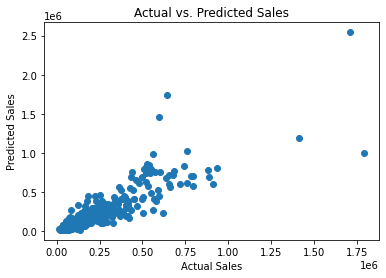

In [109]:
import matplotlib.pyplot as plt

# Create a scatter plot of predicted vs. actual values
plt.scatter(y_testd, y_pred_test)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs. Predicted Sales")
plt.show()


In [ ]:
# Predict sales for a given set of marketing inputs
new_data = pd.DataFrame({'Paid_Views': [1000], 'Organic_Views': [500], 'Google_Impressions': [20000], 'Email_Impressions': [10000], 'Facebook_Impressions': [5000], 'Affiliate_Impressions': [2000]})
new_data = sm.add_constant(new_data)  # Add the constant term
predictions = model_without_division.predict(new_data)
print("Predicted Sales:", predictions[0])


In [ ]:
# Example: Plot actual vs. predicted sales
plt.scatter(data['Sales'], model_without_division.fittedvalues)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs. Predicted Sales')
plt.show()
